<a href="https://colab.research.google.com/github/sakidja/Iridium-Ruthenium-Binary-Thermodynamic-Database/blob/main/VQE_VARIABLE___QUBITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Upload your krylov_results.zip file now...


Saving krylov_results.zip to krylov_results (1).zip
✅ Files extracted: ['H_krylov_ads_mean_size10.csv', 'H_krylov_clean_mean_size20.csv', 'H_krylov_clean_mean_size10.csv', 'Krylov_basis_clean.npy', 'H_krylov_ads_mean_size80.csv', 'H_krylov_ads_mean_size60.csv', 'H_krylov_ads_mean_size30.csv', 'H_krylov_clean_mean_size60.csv', 'H_krylov_ads_mean_size40.csv', 'H_krylov_clean_mean_size80.csv', 'H_krylov_clean_mean_size4.csv', 'H_krylov_clean_mean_size6.csv', 'H_active_clean_renorm.csv', 'H_krylov_clean_mean_size2.csv', 'H_krylov_ads_mean_size4.csv', 'H_krylov_ads_mean_size20.csv', 'H_krylov_clean_mean_size30.csv', 'H_krylov_ads_mean_size2.csv', 'Krylov_basis_ads.npy', 'H_krylov_clean_mean_size40.csv', 'H_active_ads_renorm.csv', 'H_krylov_ads_mean_size8.csv', 'H_compressed_clean.npy', 'H_compressed_ads.npy', 'H_krylov_ads_mean_size6.csv', 'H_krylov_clean_mean_size8.csv']
Run 'clean' or 'ads'? ads
✅ Loaded matrix: (32, 32)
How many qubits? (3-6): 5
✅ Using 5 qubits.
✅ Pauli decomposition co

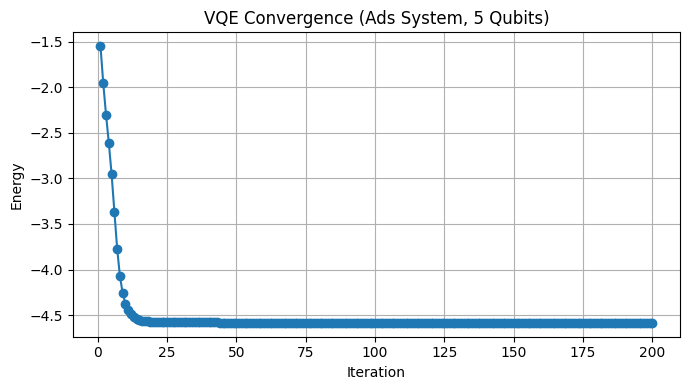

In [2]:
# ===================================================
# FULL CLEAN INTERACTIVE VQE SCRIPT in ONE CELL
# ===================================================

# Install dependencies
!pip install pennylane --quiet

# Imports
import pennylane as qml
from pennylane import numpy as np
import zipfile
import os
from itertools import product
from google.colab import files
import matplotlib.pyplot as plt

# Upload Krylov zip
print("✅ Upload your krylov_results.zip file now...")
uploaded = files.upload()

# Extract zip
zip_path = "krylov_results.zip"
extract_dir = "krylov_data"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Files extracted:", os.listdir(extract_dir))

# Choose which matrix
choice = input("Run 'clean' or 'ads'? ").strip().lower()
if choice.startswith("c"):
    filename = "H_compressed_clean.npy"
elif choice.startswith("a"):
    filename = "H_compressed_ads.npy"
else:
    raise ValueError("Invalid choice. Type 'clean' or 'ads'.")

H_matrix = np.load(os.path.join(extract_dir, filename))
print("✅ Loaded matrix:", H_matrix.shape)

# Prompt how many qubits
while True:
    try:
        n_qubits = int(input("How many qubits? (3-6): ").strip())
        if n_qubits < 3 or n_qubits > 6:
            raise ValueError
        break
    except ValueError:
        print("❌ Please enter 3, 4, 5, or 6.")

# Wires and device
wires = list(range(n_qubits))
dev = qml.device("default.qubit", wires=n_qubits)
print(f"✅ Using {n_qubits} qubits.")

# Pauli decomposition helpers
def pauli_basis(n_qubits):
    labels = ['I', 'X', 'Y', 'Z']
    return [''.join(p) for p in product(labels, repeat=n_qubits)]

def matrix_to_pauli_decomposition(H_matrix, wires):
    pauli_ops = []
    coeffs = []
    basis = pauli_basis(len(wires))
    for pauli_label in basis:
        ops = [getattr(qml, p)(w) for p, w in zip(pauli_label, wires)]
        op = ops[0]
        for o in ops[1:]:
            op = op @ o
        mat = qml.matrix(op)
        coeff = np.trace(H_matrix @ mat.conj().T) / (2 ** len(wires))
        if not np.isclose(coeff, 0.0):
            pauli_ops.append(op)
            coeffs.append(np.real_if_close(coeff))
    return qml.Hamiltonian(coeffs, pauli_ops)

H_final = matrix_to_pauli_decomposition(H_matrix, wires)
print("✅ Pauli decomposition complete.")

# Ansatz definition
def ansatz(params):
    # First layer of RY rotations
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    # Nearest-neighbor entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    # Second layer of RY rotations
    for i in range(n_qubits):
        qml.RY(params[n_qubits + i], wires=i)
    # Extra entanglement for larger qubits
    if n_qubits >= 4:
        qml.CNOT(wires=[0,2])
        qml.CNOT(wires=[1,3])
    if n_qubits >= 5:
        qml.CNOT(wires=[2,4])
    if n_qubits == 6:
        qml.CNOT(wires=[3,5])
    # Final layer of RY rotations
    for i in range(2 * n_qubits, 3 * n_qubits):
        qml.RY(params[i], wires=i - 2 * n_qubits)

print("✅ Ansatz defined.")

# QNode
@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.expval(H_final)

print("✅ QNode ready.")

# Initialize parameters
n_params = 3 * n_qubits
theta = np.random.uniform(-0.1, 0.1, n_params)
print(f"✅ Ansatz with {n_params} parameters initialized.")

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.2)

max_iterations = 200
energies = []

print("\n✅ Starting VQE optimization...\n")
for i in range(max_iterations):
    theta, energy = opt.step_and_cost(circuit, theta)
    energies.append(energy)
    print(f"Step {i+1:3d}: Energy = {energy:.6f}")

print("\n✅ Optimization complete.")
print(f"\n✅ Final Energy after {max_iterations} iterations: {energy:.6f}\n")

# Plotting energy evolution
plt.figure(figsize=(7,4))
plt.plot(range(1, max_iterations+1), energies, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title(f"VQE Convergence ({choice.capitalize()} System, {n_qubits} Qubits)")
plt.grid(True)
plt.tight_layout()
plt.show()
